In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id = '1AQ6VrAnE1xGQRM_OPPgA9dsxXlPSC-SW'
file = drive.CreateFile({'id':id}) 
file.GetContentFile('bumble_hinge_review.csv')

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load in Dataset

In [ ]:
df=pd.read_csv('bumble_hinge_review.csv', index_col=False)
df.head()

,Name,Review,Rating,#ThumbsUp,Date&Time,App,language
0,Khy McCabe,"can not seem to log into account , i have try ...",1,0,18-02-2022 00:53,Bumble,en
1,rob cif,limited view without pay money . 90 % scam acc...,1,1,18-02-2022 00:53,Bumble,en
2,abhishek bhatia,this be the most trusted but bad app . this ap...,1,0,18-02-2022 00:25,Bumble,en
3,Myles Grothaus,just a money grab . i use to love this app bef...,1,0,17-02-2022 23:55,Bumble,en
4,David Barak,the app be `` crapp . '' if i switch away from...,1,0,17-02-2022 23:55,Bumble,en


In [ ]:
bumble_less_df=df[(df['#ThumbsUp']<=1)&(df.App=='Bumble')]
bumble_less_reviews = bumble_less_df['Review'].tolist()

In [ ]:
bumble_less_df.shape

(63635, 7)

In [ ]:
bumble_more_df=df[(df['#ThumbsUp']>1)&(df.App=='Bumble')]
bumble_more_reviews = bumble_more_df['Review'].tolist()

In [ ]:
bumble_more_df.shape

(15258, 7)

# Downsampling

In [ ]:
from random import sample
import random

random.seed(0)
sampled_bumble_less_reviews = sample(bumble_less_reviews,15258)

docs = sampled_bumble_less_reviews + bumble_more_reviews
labels = np.concatenate([np.zeros(15258), np.ones(15258)])

In [ ]:
len(docs)

30516

# Load in Keras Toolkit

In [ ]:
# VOCAB_SIZE = 27000
from keras.layers import Input, Dense, LSTM, Flatten, concatenate, Activation, RepeatVector, Permute
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
# from keras.optimizers import Adam
#from keras_self_attention import SeqSelfAttention
import numpy as np 
import spacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
from random import randint
from numpy import array, argmax, asarray, zeros
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding

# Tokenize Text

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(docs)

# Integer Encode Documents

In [ ]:
from typing import List
def get_max_token_length_per_doc(docs: List[List[str]])-> int:
    return max(list(map(lambda x: len(x.split()), docs)))

# get the max length in terms of token length
max_length = get_max_token_length_per_doc(docs)


def integer_encode_documents(docs, tokenizer):
    return tokenizer.texts_to_sequences(docs)

from keras.preprocessing.sequence import pad_sequences
MAX_SEQUENCE_LENGTH = 300
# integer encode the documents
encoded_docs = integer_encode_documents(docs, tokenizer)
# this is a list of lists, the numbers represent the index position of that word.
# for instance, 33 means the 33rd word in the vocabulary
padded_docs = pad_sequences(encoded_docs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# Load in GloVe Vectors

In [ ]:
!wget https://dso-560-nlp-text-analytics.s3.amazonaws.com/glove6b100dtxt.zip
!unzip glove6b100dtxt.zip 

--2022-05-12 18:29:55--  https://dso-560-nlp-text-analytics.s3.amazonaws.com/glove6b100dtxt.zip
Resolving dso-560-nlp-text-analytics.s3.amazonaws.com (dso-560-nlp-text-analytics.s3.amazonaws.com)... 54.231.195.121
Connecting to dso-560-nlp-text-analytics.s3.amazonaws.com (dso-560-nlp-text-analytics.s3.amazonaws.com)|54.231.195.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137847651 (131M) [application/zip]
Saving to: ‘glove6b100dtxt.zip’

glove6b100dtxt.zip  100%[===================>] 131.46M  52.9MB/s    in 2.5s    

2022-05-12 18:29:57 (52.9 MB/s) - ‘glove6b100dtxt.zip’ saved [137847651/137847651]

Archive:  glove6b100dtxt.zip
  inflating: glove.6B.100d.txt       


In [ ]:
def load_glove_vectors():
    embeddings_index = {}
    with open('glove.6B.100d.txt') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index


embeddings_index = load_glove_vectors()

Loaded 400000 word vectors.


# Load in Embeddings Matrix

In [ ]:
VOCAB_SIZE=int(len(tokenizer.word_index)*1.1)

In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((VOCAB_SIZE, 100))
# print(tokenizer.word_index.items())
for word, i in tokenizer.word_index.items():
    # print(embeddings_index.get(word))
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix[i] = embedding_vector

# Define an LSTM Model

In [ ]:
!pip install keras_self_attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18912 sha256=b26e6b4d924e58aa210de9555fd1353dc9953f93c43ee9759d47cf8e3db1f464
  Stored in directory: /root/.cache/pip/wheels/95/b1/a8/5ee00cc137940b2f6fa198212e8f45d813d0e0d9c3a04035a3
Successfully built keras-self-attention


In [ ]:
import keras
from keras_self_attention import SeqSelfAttention


model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=VOCAB_SIZE,
                                 output_dim=100,
                                 mask_zero=True))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=32,
                                                       return_sequences=True)))
model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.add(keras.layers.Dense(units=5))
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1717200   
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         34048     
 l)                                                              
                                                                 
 seq_self_attention (SeqSelf  (None, None, 64)         4161      
 Attention)                                                      
                                                                 
 dense (Dense)               (None, None, 5)           325       
                                                                 
Total params: 1,755,734
Trainable params: 1,755,734
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers import Flatten, Masking

def make_lstm_classification_model(plot=False):
    model = keras.models.Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(LSTM(units=64, input_shape=(1, MAX_SEQUENCE_LENGTH)))
    model.add(Dense(16))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [ ]:
model = make_lstm_classification_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 100)          1717200   
                                                                 
 masking (Masking)           (None, 300, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,760,497
Trainable params: 43,297
Non-trainable params: 1,717,200
_________________________________________________________________


# Split Into Train/Test

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.2)

# Fit the Model

In [ ]:
# fit the model
history = model.fit(X_train,  y_train, validation_split = 0.1, epochs=5, verbose=1)

Epoch 1/5
687/687 [==============================] - 320s 455ms/step - loss: 0.5780 - accuracy: 0.7035 - val_loss: 0.5701 - val_accuracy: 0.7101
Epoch 2/5
687/687 [==============================] - 300s 437ms/step - loss: 0.5563 - accuracy: 0.7182 - val_loss: 0.5695 - val_accuracy: 0.7068
Epoch 3/5
687/687 [==============================] - 300s 437ms/step - loss: 0.5475 - accuracy: 0.7226 - val_loss: 0.5672 - val_accuracy: 0.7113
Epoch 4/5
687/687 [==============================] - 301s 438ms/step - loss: 0.5395 - accuracy: 0.7298 - val_loss: 0.5700 - val_accuracy: 0.7117
Epoch 5/5
687/687 [==============================] - 305s 444ms/step - loss: 0.5310 - accuracy: 0.7348 - val_loss: 0.5734 - val_accuracy: 0.7101


# Evaluate the Model 

In [ ]:
loss,accuracy=model.evaluate(X_test,y_test,verbose=1)
print('Accuracy: %f' % (accuracy*100))

191/191 [==============================] - 15s 80ms/step - loss: 0.5493 - accuracy: 0.7318
Accuracy: 73.181522


In [ ]:
model.predict(X_test)

array([[0.42087263],
       [0.03549394],
       [0.3139401 ],
       ...,
       [0.75858563],
       [0.50076866],
       [0.53047025]], dtype=float32)

In [ ]:
prob=model.predict(X_test)

In [ ]:
y_pred = [1 * (x[0]>=0.5) for x in prob]

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[2271,  796],
       [ 841, 2196]])

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure()
    lw = 2
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkorange',
    lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

<Figure size 432x288 with 0 Axes>

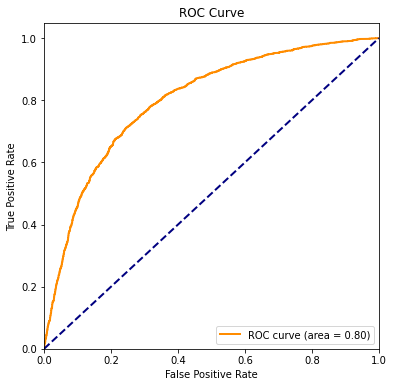

In [ ]:
fpr, tpr, thersholds = roc_curve(y_test, prob)
roc_auc = auc(fpr, tpr)
plot_roc_curve(fpr, tpr, roc_auc)